In [1]:
import numpy as np
import jax
import matplotlib.pyplot as plt

# Gaussian process(100 dimensional Gaussian)

Mean is taken to be a vector of ones and covariance matrix comprises the product of linear and square exponential kernels plus small white noise. i.e. 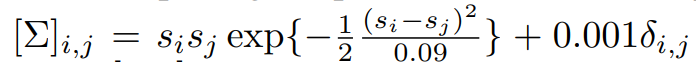

To obtain this true covariance matrix, we do the following:
1. Create a grid of inputs s from 1 to 2.
2. Initialize a covariance matrix $\Sigma$ with the appropriate dimensions (100x100 in this case).
3. Fill in the matrix with the covariance function provided.
4. Add white noise to the diagonal.

In [2]:
mu = np.ones(100)
# Step 1
s = np.linspace(1, 2, 100)
# Step 2
cov = np.zeros((100, 100))

# Step 3
for i in range(100):
    for j in range(100):
        cov[i, j] = s[i] * s[j] * np.exp(-0.5* ((s[i] - s[j])**2)/ 0.09)

# Step 4
cov += np.eye(100) * 0.001

In [3]:
cov

array([[1.001     , 1.00952861, 1.01789149, ..., 0.00955815, 0.00860162,
        0.00773184],
       [1.00952861, 1.02130405, 1.02992313, ..., 0.01077085, 0.00970395,
        0.00873261],
       [1.01789149, 1.02992313, 1.04181216, ..., 0.01212246, 0.01093406,
        0.00985075],
       ...,
       [0.00955815, 0.01077085, 0.01212246, ..., 3.92060004, 3.93736553,
        3.95062837],
       [0.00860162, 0.00970395, 0.01093406, ..., 3.93736553, 3.96069799,
        3.97754273],
       [0.00773184, 0.00873261, 0.00985075, ..., 3.95062837, 3.97754273,
        4.001     ]])

In [4]:
# define necessary functions
def multivariate_gaussian(x, mu, cov):
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

def log_gauss(x, mu, cov):
    scale = np.linalg.cholesky(cov)
    v = jax.lax.linalg.triangular_solve(
      scale, x - mu, left_side=True, lower=True
    )
    return -0.5 * np.sum(v * v)

def grad_log_gauss(x,mu,cov):
    scale = np.linalg.cholesky(cov)
    v = jax.lax.linalg.triangular_solve(
      scale, x - mu, left_side=True, lower=True
    )
    return - jax.lax.linalg.triangular_solve(
      np.transpose(scale), v, left_side=True, lower=False
    )

# Fisher MALA algorithm 

## step 1. simple MALA for initialisation

In [5]:
# initialisation 
lam = 10 # default value
average_acc_rate = 0.574 # adapt step size toward achieving this acceptance rate. 
rho = 0.015 # default 

In [6]:
rng = np.random.default_rng(36)
# number of iteration
N = 500

# initialise step size which is sigma^2 in paper
# 0.002 seems reasonable from trials
step_size = 0.002

acceptance_rate_collection =  []
#initial sample obtained by drawing from standard normal as stated

x = rng.normal(0,1,100) # initial value

# 500 iterations. 
for _ in range(N):
    
    # obtain x' through the formula
    y = x + (step_size/2) * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,len(mu))
    
    # Metropolis
    u = rng.uniform(0, 1)
    
    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(len(mu))) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(len(mu))))
    # if u < acceptance rate, we accept the sample 
    if np.log(u) < log_acc_rate:
        x = y
        
    else:
        x = x
        
    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))
    acceptance_rate_collection.append(acc_rate)
    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    
    
print(f'Final sample in first 500 iterations:{x}')
print(f'Final adapted step size in first 500 iterations:{step_size}')

C:\Users\kaixi\AppData\Local\Temp\ipykernel_3872\2537505777.py:33: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_acc_rate))


Final sample in first 500 iterations:[-1.19742811e-01 -2.31670484e-01 -2.48064771e-01 -2.08236516e-01
 -2.46360987e-01 -2.22062916e-01 -2.18360066e-01 -2.46645540e-01
 -2.65121460e-01 -3.14131498e-01 -3.17474455e-01 -2.66847372e-01
 -2.83939302e-01 -2.67544925e-01 -2.11200640e-01 -2.64810592e-01
 -2.42715359e-01 -2.02975065e-01 -1.98775381e-01 -2.20049381e-01
 -1.91040441e-01 -1.60521209e-01 -1.75286561e-01 -1.53526038e-01
 -1.01900674e-01 -1.02826864e-01 -6.52260035e-02 -1.08450994e-01
 -7.90472329e-02 -4.83104959e-02 -1.99842062e-02 -5.11701517e-02
 -2.23177765e-03  4.60407324e-03  2.58760042e-02  1.88401877e-03
 -1.27545493e-02  2.06638966e-02 -3.20747495e-06 -6.17929175e-03
  8.36563110e-03 -1.17304930e-02 -1.89203490e-02 -1.32534076e-02
  1.25341229e-02  3.85689512e-02  6.86636847e-03 -2.04036832e-02
  3.10859662e-02 -3.71144824e-02  9.50708985e-04 -5.03487326e-03
  2.25685686e-02  5.81083260e-02  5.34931719e-02  6.20138198e-02
  2.57222410e-02  9.34240595e-02  9.76162776e-03  1.1

In [7]:
# This can be used as a metric to choose a good initial step size 
print(f'average acceptance rate:{np.mean(acceptance_rate_collection)}')

average acceptance rate:0.43157955538862974


Overflow does not matter as it is dealt with by min function.

## step 2. Fisher MALA

In [8]:
# initialisation
N = int(1.95 * 10**4)
step_size_R = step_size # adapted step size from final iteration above. place holder for normalised step size.
R = np.identity(len(mu)) # initialise the square root matrix with identity matrix.

# define function h as stated in proposition 1. 
def h(z,v, step_size, R, mu, cov):
    return (1/2) * (z- v- (step_size/4)* (R @ (R.T)).dot(grad_log_gauss(v, mu, cov))).dot(grad_log_gauss(v, mu, cov))

In [9]:
acc_rate_collection = []

normalised_preconditioner_fisher = []

for n in range(1,N+1):
    
    # append normalised matrix to a list for plotting Frobenius norm later 
    normalised_preconditioner_fisher.append(R@R.T/(1/len(mu) * np.trace(R@R.T)))
    y = x + step_size_R/2 * R.dot(R.T.dot(grad_log_gauss(x, mu, cov))) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,len(mu)))
    
    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(x, y, step_size_R, R, mu, cov) -\
                     log_gauss(x, mu, cov) - h(y, x, step_size_R, R, mu, cov)))
    
    # collect acceptance rate
    acc_rate_collection.append(acc_rate)
    
    # compute adaptation signal for updating R later
    s = np.sqrt(acc_rate) * (grad_log_gauss(y, mu, cov) - grad_log_gauss(x, mu, cov))
    
    # use s to adapt R based on proposition 4
    if n == 1:
        r1 = 1/(1+ np.sqrt(lam/(lam + np.dot(s,s))))
        R = (1/ np.sqrt(lam))* (R - r1 * (np.outer(s,s)/(lam + np.dot(s,s))))
    else:
        phi = (R.T).dot(s)
        r = 1/(1+ np.sqrt(1/ (1+np.dot(phi,phi))))
        R = R - r * np.outer((R.dot(phi)),phi)/(1+ np.dot(phi,phi))
       
    # adapt step size using the formula. mistake here in 1st version
    # let the step size adapt as before in Simple MALA
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    
    # normalise the step size for the proposal in next iteration.
    step_size_R = step_size / ((1/len(mu)) * np.trace(R @ (R.T))) 
    
    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)
    
    if u < acc_rate:
        x = y
        
    else:
        x = x
    

In [10]:
print(f'Final sample after burn-in iterations:{x}')
print(f'Final step size after burn-in iterations:{step_size}')
print(f'Final adapted normalised step size after burn-in iterations:{step_size_R}')
print(f'Average acceptance rate:{np.mean(acc_rate_collection)}')
print(f'Adapted square root matrix:{R}')

Final sample after burn-in iterations:[ 0.00625849  0.0673275  -0.02647042 -0.01997983 -0.02518606 -0.08990955
 -0.13121223 -0.18591464 -0.18699789 -0.16957033 -0.26586664 -0.2511537
 -0.2776611  -0.3106351  -0.36079526 -0.40408587 -0.3667847  -0.47594905
 -0.45334637 -0.44630027 -0.5313171  -0.56824815 -0.5418966  -0.62858653
 -0.60181904 -0.6394042  -0.6753479  -0.7275422  -0.7372437  -0.7153219
 -0.7330774  -0.7643013  -0.7855427  -0.8570383  -0.7630193  -0.84602606
 -0.8232756  -0.85325    -0.8066581  -0.84998566 -0.7879816  -0.7892932
 -0.8938339  -0.84948325 -0.8486768  -0.8059064  -0.7138417  -0.7721299
 -0.7065418  -0.71489346 -0.6593913  -0.66885656 -0.5869436  -0.6049241
 -0.5363872  -0.5175483  -0.53019965 -0.41092032 -0.40475202 -0.3812775
 -0.2957362  -0.2243242  -0.14012793 -0.11136156 -0.08963904 -0.08499536
  0.00845423  0.07360226  0.07949391  0.1639812   0.11742437  0.2544596
  0.31624892  0.3133977   0.34829378  0.36811826  0.39869958  0.42957753
  0.4630361   0.4720

In [11]:
normalised_fisher_preconditioner = (R@R.T)/(1/len(mu) * np.trace(R@R.T))
print(f'normalised preconditioning matrix:{normalised_fisher_preconditioner}')

normalised preconditioning matrix:[[0.43568869 0.43916499 0.4427476  ... 0.002415   0.00223826 0.00200182]
 [0.43916499 0.44404566 0.4477372  ... 0.00313752 0.00291454 0.0026279 ]
 [0.4427476  0.4477372  0.45284686 ... 0.00359685 0.00332514 0.00300032]
 ...
 [0.002415   0.00313752 0.00359685 ... 1.68409235 1.69181419 1.69771459]
 [0.00223826 0.00291454 0.00332514 ... 1.69181419 1.70235289 1.70979414]
 [0.00200182 0.0026279  0.00300032 ... 1.69771459 1.70979414 1.72009307]]


In [12]:
print(f'normalised true covariance matrix:{cov/(1/len(mu) * np.trace(cov))}')

normalised true covariance matrix:[[0.42850719 0.43215811 0.43573808 ... 0.00409164 0.00368217 0.00330984]
 [0.43215811 0.43719893 0.44088857 ... 0.00461078 0.00415406 0.00373825]
 [0.43573808 0.44088857 0.44597802 ... 0.00518937 0.00468064 0.0042169 ]
 ...
 [0.00409164 0.00461078 0.00518937 ... 1.67832696 1.68550392 1.69118146]
 [0.00368217 0.00415406 0.00468064 ... 1.68550392 1.69549206 1.70270294]
 [0.00330984 0.00373825 0.0042169  ... 1.69118146 1.70270294 1.71274451]]


# AdaMALA
## step1. 500 simple MALA initialisation to adapt step size.

In [13]:
rng = np.random.default_rng(36)
# number of iteration
N = 500

# initialise step size which is sigma^2 in paper
# 0.002 seems reasonable from trials
step_size = 0.002

acceptance_rate_collection =  []

#initial sample obtained by drawing from standard normal as stated
x = rng.normal(0,1,100) # initial value

# 500 iterations. 
for _ in range(N):
    
    # obtain x' through the formula
    y = x + (step_size/2) * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,len(mu))
    
    # Metropolis
    u = rng.uniform(0, 1)
    
    # mistake in sign in first version. 
    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(len(mu))) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(len(mu))))

    # if u < acceptance rate, we accept the sample 
    if np.log(u) < log_acc_rate:
        x = y
        
    else:
        x = x
        
    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))
    acceptance_rate_collection.append(acc_rate)
    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    
    
print(f'Final sample in first 500 iterations:{x}')
print(f'Final adapted step size in first 500 iterations:{step_size}')

C:\Users\kaixi\AppData\Local\Temp\ipykernel_3872\952521792.py:35: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_acc_rate))


Final sample in first 500 iterations:[-1.19742811e-01 -2.31670484e-01 -2.48064771e-01 -2.08236516e-01
 -2.46360987e-01 -2.22062916e-01 -2.18360066e-01 -2.46645540e-01
 -2.65121460e-01 -3.14131498e-01 -3.17474455e-01 -2.66847372e-01
 -2.83939302e-01 -2.67544925e-01 -2.11200640e-01 -2.64810592e-01
 -2.42715359e-01 -2.02975065e-01 -1.98775381e-01 -2.20049381e-01
 -1.91040441e-01 -1.60521209e-01 -1.75286561e-01 -1.53526038e-01
 -1.01900674e-01 -1.02826864e-01 -6.52260035e-02 -1.08450994e-01
 -7.90472329e-02 -4.83104959e-02 -1.99842062e-02 -5.11701517e-02
 -2.23177765e-03  4.60407324e-03  2.58760042e-02  1.88401877e-03
 -1.27545493e-02  2.06638966e-02 -3.20747495e-06 -6.17929175e-03
  8.36563110e-03 -1.17304930e-02 -1.89203490e-02 -1.32534076e-02
  1.25341229e-02  3.85689512e-02  6.86636847e-03 -2.04036832e-02
  3.10859662e-02 -3.71144824e-02  9.50708985e-04 -5.03487326e-03
  2.25685686e-02  5.81083260e-02  5.34931719e-02  6.20138198e-02
  2.57222410e-02  9.34240595e-02  9.76162776e-03  1.1

## Another 500 iterations to adapt covariance matrix 

In [14]:
# initialisation mu with final sample from first 500 iterations.
mean = x

# number of iteration
N = 500

normalised_preconditioner_ada = []
acc_rate_collection = []

# 500 iterations. 
for n in range(2, N+2):
    
    # obtain x' through the formula
    y = x + (step_size/2 * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,len(mu)))
    
    
    # Metropolis
    u = rng.uniform(0, 1)
    
    # mistake in sign in first version. 
    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(len(mu))) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(len(mu))))

    # if u < acceptance rate, we accept the sample 
    if np.log(u) < log_acc_rate:
        x = y
        
    else:
        x = x
        
        
    if n == 2:
        Sigma = (1/n)* np.outer((x-mean),(x-mean)) + lam * np.identity(len(mu))
    
    else:
        Sigma = ((n-2)/(n-1)) * Sigma + 1/n * np.outer((x-mean), (x-mean))
        
    # append normalised matrix for plot of Frobenius norm 
    normalised_preconditioner_ada.append(Sigma/(1/len(mu) * np.trace(Sigma)))
        
    mean = ((n-1)/n) * mean + 1/n * x
        
    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))
    acc_rate_collection.append(acc_rate)


    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))

print(f'Final empirical covariance after 500 iterations:{Sigma}')
print(f'Final empirical mean after 500 iterations:{mean}')
print(f'Final adapted step size after first 1000 iterations:{step_size}')
print(f'Average acceptance rate:{np.mean(acc_rate_collection)}')

Final empirical covariance after 500 iterations:[[ 2.17493346e-02  9.40385525e-04  1.11683029e-03 ...  4.54856849e-04
  -3.44312685e-04 -4.60885664e-05]
 [ 9.40385525e-04  2.22583736e-02  1.78442136e-03 ...  7.64435970e-04
   1.79535216e-04  1.86165769e-04]
 [ 1.11683029e-03  1.78442136e-03  2.32277352e-02 ...  1.04953055e-03
   3.21947131e-05  2.94219265e-05]
 ...
 [ 4.54856849e-04  7.64435970e-04  1.04953055e-03 ...  2.18053517e-02
   1.10873154e-03  1.04345809e-03]
 [-3.44312685e-04  1.79535216e-04  3.21947131e-05 ...  1.10873154e-03
   2.30808042e-02  1.67370979e-03]
 [-4.60885664e-05  1.86165769e-04  2.94219265e-05 ...  1.04345809e-03
   1.67370979e-03  2.23237832e-02]]
Final empirical mean after 500 iterations:[-0.12178797 -0.11692251 -0.12140762 -0.12341125 -0.11482792 -0.12211864
 -0.11808071 -0.11555928 -0.11918851 -0.11933833 -0.11935996 -0.113901
 -0.11305033 -0.11339852 -0.11579367 -0.1083969  -0.1125748  -0.10677021
 -0.11320142 -0.10849823 -0.09905489 -0.11133158 -0.09983

## For remaining burn-in iterations adapt covariance using proposal in (7).

In [15]:
# initialisation
N = int(1.9 * 10**4)

step_size_R = step_size # adapted step size from final iteration above. place holder for normalised step size.

acc_rate_collection = []

mean = mean # final sample from above
Sigma = Sigma # from above. 

# for n in range(3,N+3):
for n in range(502,N+502):
    R = np.linalg.cholesky(Sigma)

    y = x + step_size_R/2 * Sigma.dot(grad_log_gauss(x, mu, cov)) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,len(mu)))
    #print(f'new sample:{y}')

    
    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(x, y, step_size_R, R, mu, cov) -\
                     log_gauss(x, mu, cov) - h(y, x, step_size_R, R, mu, cov)))
    
    # collect acceptance rate
    acc_rate_collection.append(acc_rate)
    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)
    
    if u < acc_rate:
        x = y
        
    else:
        x = x
        

    Sigma = ((n-2)/(n-1)) * Sigma + 1/n * np.outer((x-mean), (x-mean))
    
    mean = (n-1)/n * mean + 1/n * x
    
    #print(f'empirical covariance update:{Sigma}')
    
    # appending the normalised preconditioner for later plot of Frobenius norm
    normalised_preconditioner_ada.append(Sigma/(1/len(mu) * np.trace(Sigma)))


    # let the step size adapt as before in Simple MALA
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    
    # normalise the step size for the proposal in next iteration.
    step_size_R = step_size / ((1/len(mu)) * np.trace(Sigma)) 

In [16]:
print(f'Final empirical covariance after burn-in iterations:\n{Sigma}')
print(f'Final empirical mean after burn-in iterations:\n{mean}')
print(f'Average acceptance rate:{np.mean(acc_rate_collection)}')

Final empirical covariance after burn-in iterations:
[[0.86344272 0.86882763 0.87498057 ... 0.16540452 0.17227107 0.17673675]
 [0.86882763 0.87814775 0.88365385 ... 0.16334068 0.17009299 0.17450277]
 [0.87498057 0.88365385 0.89305987 ... 0.16377765 0.17051648 0.17480364]
 ...
 [0.16540452 0.16334068 0.16377765 ... 2.35911991 2.36651085 2.37310481]
 [0.17227107 0.17009299 0.17051648 ... 2.36651085 2.37971025 2.38782446]
 [0.17673675 0.17450277 0.17480364 ... 2.37310481 2.38782446 2.40219452]]
Final empirical mean after burn-in iterations:
[0.67906183 0.6731671  0.66741794 0.6609146  0.6556054  0.6506437
 0.64352924 0.6381399  0.63286316 0.62610996 0.6225918  0.6169791
 0.6125529  0.6085676  0.60280246 0.598573   0.5951013  0.5903095
 0.5878063  0.58393466 0.5810131  0.57908654 0.575153   0.5721157
 0.5712676  0.56927526 0.5670347  0.56730765 0.56464565 0.56539863
 0.5667517  0.56595385 0.56722355 0.56906414 0.569725   0.5708701
 0.57491755 0.57808274 0.58074224 0.5847846  0.58900326 0.5

Mean is not converging.

In [17]:
normalised_precondioner_ada = Sigma/(np.trace(Sigma)/len(mu))
print(f'normalised adaMALA precondioner:{normalised_precondioner_ada}')

normalised adaMALA precondioner:[[0.56383442 0.5673508  0.57136872 ... 0.10801036 0.11249427 0.11541039]
 [0.5673508  0.57343691 0.57703243 ... 0.10666266 0.11107197 0.11395159]
 [0.57136872 0.57703243 0.58317463 ... 0.106948   0.11134851 0.11414806]
 ...
 [0.10801036 0.10666266 0.106948   ... 1.54052257 1.54534891 1.5496548 ]
 [0.11249427 0.11107197 0.11134851 ... 1.54534891 1.55396821 1.55926685]
 [0.11541039 0.11395159 0.11414806 ... 1.5496548  1.55926685 1.5686506 ]]


# Frobenius norm

In [20]:
normalised_cov = cov/(1/len(mu) * np.trace(cov))
difference_ada = normalised_preconditioner_ada - normalised_cov
difference_fisher = normalised_preconditioner_fisher - normalised_cov
fro_norm_ada = []
fro_norm_fisher = []
for i in difference_ada:
    fro_norm_ada.append(np.linalg.norm(i))
    
for j in difference_fisher:
    fro_norm_fisher.append(np.linalg.norm(j))

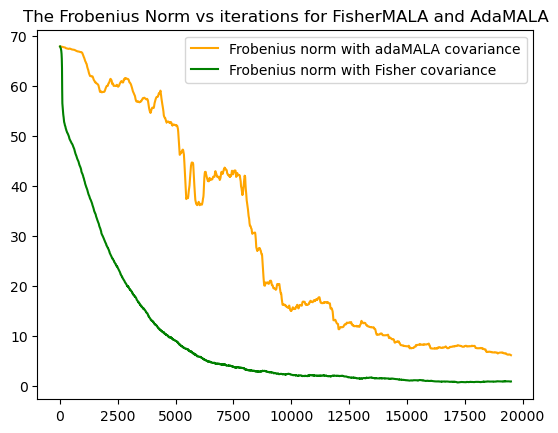

In [21]:
iterations = np.arange(0, int(1.95 * 10**4))
plt.plot(iterations, fro_norm_ada, label = 'Frobenius norm with adaMALA covariance', color = 'orange')
plt.plot(iterations, fro_norm_fisher, label = 'Frobenius norm with Fisher covariance', color = 'green')
plt.title('The Frobenius Norm vs iterations for FisherMALA and AdaMALA')
plt.legend()
plt.show()

In [22]:
print(f'Frobenius norm from AdaMALA converges to:{fro_norm_ada[-1]}')
print(f'Frobenius norm from FisherMALA converges to:{fro_norm_fisher[-1]}')

Frobenius norm from AdaMALA converges to:6.095167550683608
Frobenius norm from FisherMALA converges to:0.8282129441642547


FisherMALA clearly learns much faster and achieve more accurate estimates of the optimal preconditioner compared to adaMALA. 

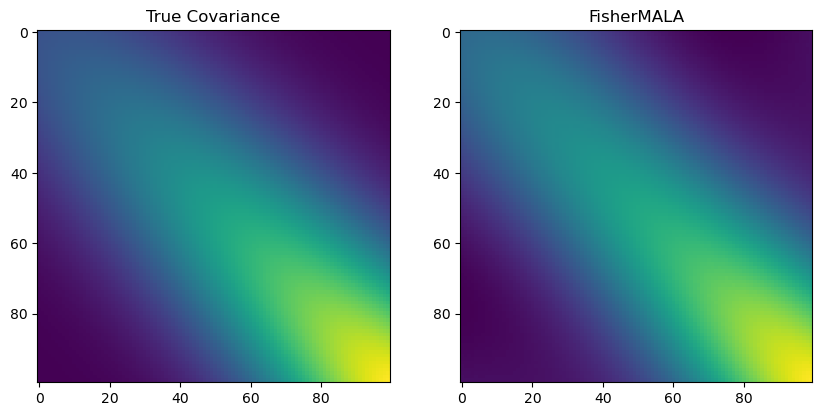

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the true covariance matrix on the first subplot
axs[0].imshow(cov)
axs[0].set_title('True Covariance')

# Plot the estimated covariance matrix on the second subplot
axs[1].imshow(R @ R.T)
axs[1].set_title('FisherMALA')

# Display the plots
plt.show()